In [ ]:
#importing required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [ ]:
# Load training and test datasets
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")


print(train_data.head())
print(test_data.head())

     id                              belongs_to_collection    budget  \
0   272                                                NaN  72500000   
1  2804                                                NaN         0   
2  2549  [{'id': 10456, 'name': 'Dirty Harry Collection...         0   
3   260                                                NaN     24554   
4   532                                                NaN         0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 10751, 'name': 'Family'}, {'id': 28, '...   
2  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
3                      [{'id': 18, 'name': 'Drama'}]   
4  [{'id': 99, 'name': 'Documentary'}, {'id': 104...   

                                            homepage    imdb_id  \
0  http://www.sonypictures.com/homevideo/talladeg...  tt0415306   
1                                                NaN  tt0305396   
2                            

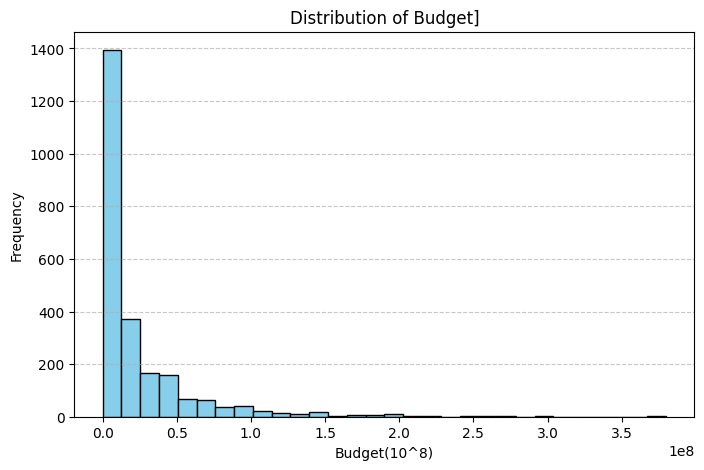

In [ ]:
# Histogram for budget
plt.figure(figsize=(8, 5))
plt.hist(train_data['budget'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Budget]")
plt.xlabel("Budget(10^8)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

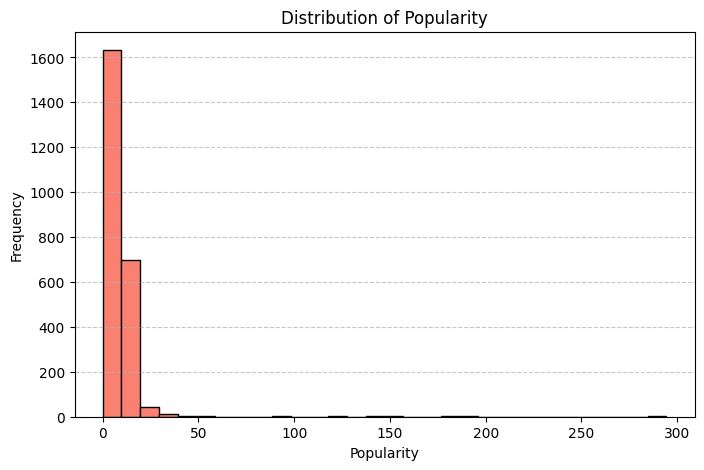

In [ ]:
# Histogram for popularity
plt.figure(figsize=(8, 5))
plt.hist(train_data['popularity'], bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


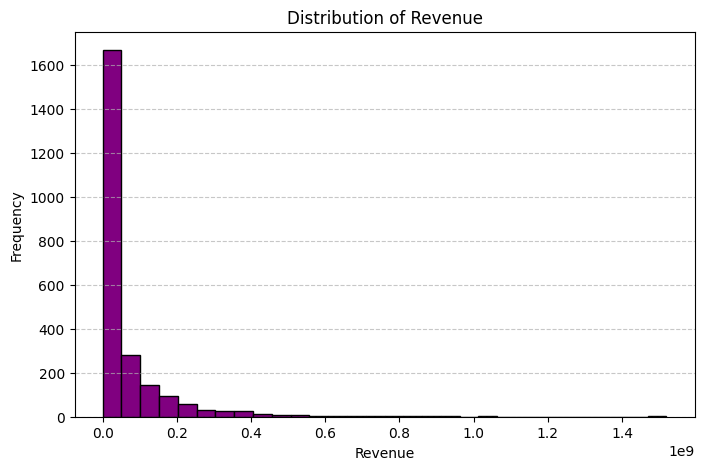

In [ ]:
import matplotlib.pyplot as plt

# Histogram for revenue
plt.figure(figsize=(8, 5))
plt.hist(train_data['revenue'], bins=30, color='purple', edgecolor='black')
plt.title("Distribution of Revenue")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


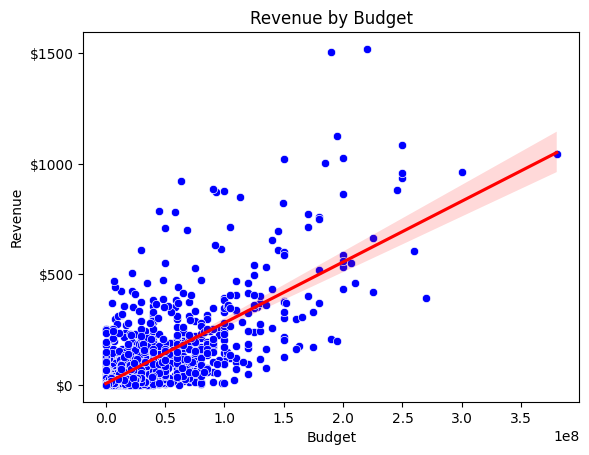

In [ ]:
import seaborn as sns

# Revenue Range
revenue_breaks = [0, 500_000_000, 1_000_000_000, 1_500_000_000]
revenue_labels = ['$0', '$500', '$1000', '$1500']

# Budget vs Revenue
sns.scatterplot(x='budget', y='revenue', data=train_data, color='blue')
sns.regplot(x='budget', y='revenue', data=train_data, scatter=False, color='red')
plt.title("Revenue by Budget")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.yticks(revenue_breaks, revenue_labels)
plt.show()

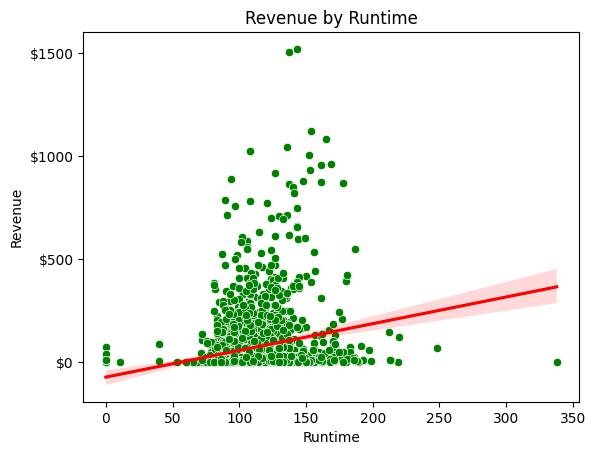

In [ ]:
# Runtime vs Revenue
sns.scatterplot(x='runtime', y='revenue', data=train_data, color='green')
sns.regplot(x='runtime', y='revenue', data=train_data, scatter=False, color='red')
plt.title("Revenue by Runtime")
plt.xlabel("Runtime")
plt.ylabel("Revenue")
plt.yticks(revenue_breaks, revenue_labels)
plt.show()

# Popularity vs Revenue


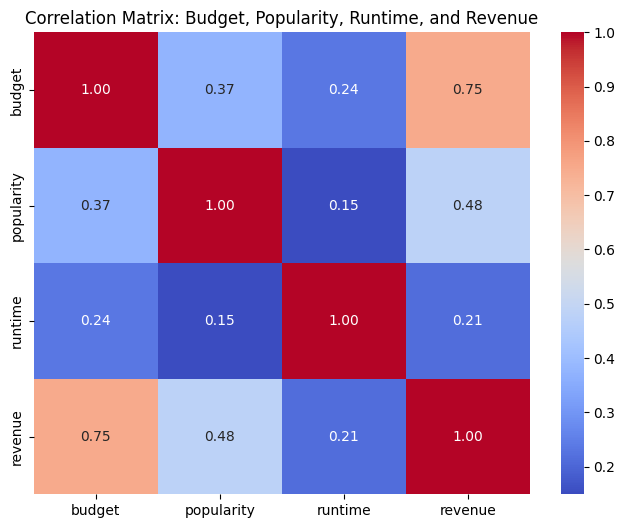

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the specific columns for correlation
selected_features = ['budget', 'popularity', 'runtime', 'revenue']
correlation_matrix = train_data[selected_features].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix: Budget, Popularity, Runtime, and Revenue")
plt.show()


In [ ]:
# To remove skewness in our target variable
train_data['log_revenue'] = np.log(train_data['revenue'].replace(0, np.nan))

###Extract useful information from the columns

In [ ]:
import re

# Cleaning 'belongs_to_collection' and renaming to 'collection_name_cleaned'
train_data['collection_name_cleaned'] = train_data['belongs_to_collection'].apply(
    lambda x: re.search(r"(?<=name'\:\s{1}')[^']+(?=',\s{1}'poster)", x).group() if pd.notnull(x) and x != "" and re.search(r"(?<=name'\:\s{1}')[^']+(?=',\s{1}'poster)", x) else None
)

# Cleaning 'spoken_languages' and renaming to 'language_cleaned'
train_data['language_cleaned'] = train_data['spoken_languages'].apply(
    lambda x: re.search(r"(?<=iso_639_1'\:\s{1}')[a-z]{2}", x).group() if pd.notnull(x) and x != "" and re.search(r"(?<=iso_639_1'\:\s{1}')[a-z]{2}", x) else None
)

# Cleaning 'genres' and renaming to 'genre_cleaned'
train_data['genre_cleaned'] = train_data['genres'].apply(
    lambda x: re.search(r"(?<=name'\:\s{1}')[^']+", x).group() if pd.notnull(x) and x != "" and re.search(r"(?<=name'\:\s{1}')[^']+", x) else None
)

# Cleaning 'cast' and renaming to 'main_cast_cleaned'
train_data['main_cast_cleaned'] = train_data['cast'].apply(
    lambda x: re.search(r"(?<=name'\:\s{1}')[^']+", x).group() if pd.notnull(x) and x != "" and re.search(r"(?<=name'\:\s{1}')[^']+", x) else None
)

# Cleaning 'production_countries' and renaming to 'prod_country_code_cleaned'
train_data['prod_country_code_cleaned'] = train_data['production_countries'].apply(
    lambda x: re.search(r"(?<=iso_3166_1'\:\s{1}')[A-Z]{2}", x).group() if pd.notnull(x) and x != "" and re.search(r"(?<=iso_3166_1'\:\s{1}')[A-Z]{2}", x) else None
)

# Cleaning 'production_companies' and renaming to 'prod_company_cleaned'
train_data['prod_company_cleaned'] = train_data['production_companies'].apply(
    lambda x: re.search(r"(?<=name'\:\s{1}')[^']+", x).group() if pd.notnull(x) and x != "" and re.search(r"(?<=name'\:\s{1}')[^']+", x) else None
)

# Extracting 'director_entry' and renaming to 'director_entry_cleaned'
train_data['director_entry_cleaned'] = train_data['crew'].apply(
    lambda x: re.search(r"\{[^}]+'department':\s*'Directing'[^}]+'job':\s*'Director'[^}]+'name':\s*'[^']+'", x).group() if pd.notnull(x) and x != "" and re.search(r"\{[^}]+'department':\s*'Directing'[^}]+'job':\s*'Director'[^}]+'name':\s*'[^']+'", x) else None
)

# Extracting director name from 'director_entry_cleaned' and renaming to 'director_name_cleaned'
train_data['director_name_cleaned'] = train_data['director_entry_cleaned'].apply(
    lambda x: re.search(r"'name':\s*'([^']+)'", x).group(1) if pd.notnull(x) and re.search(r"'name':\s*'([^']+)'", x) else None
)


In [ ]:


# Extracting numbers of cast and crew
train_data['num_cast'] = train_data['cast'].apply(lambda x: len(re.findall(r"\{[^}]*\}", x)) if pd.notnull(x) else 0)
train_data['num_crew'] = train_data['crew'].apply(lambda x: len(re.findall(r"\{[^}]*\}", x)) if pd.notnull(x) else 0)

# Initialize columns for gender counts in cast
train_data['unknowngender_cast'] = 0
train_data['female_cast'] = 0
train_data['male_cast'] = 0

# Count genders in cast
for i in range(len(train_data)):
    cast = train_data.loc[i, 'cast']
    if pd.notnull(cast):
        train_data.loc[i, 'unknowngender_cast'] = len(re.findall(r"'gender': 0", cast))
        train_data.loc[i, 'female_cast'] = len(re.findall(r"'gender': 1", cast))
        train_data.loc[i, 'male_cast'] = len(re.findall(r"'gender': 2", cast))

# Initialize columns for gender counts in crew
train_data['unknowngender_crew'] = 0
train_data['female_crew'] = 0
train_data['male_crew'] = 0

# Count genders in crew
for i in range(len(train_data)):
    crew = train_data.loc[i, 'crew']
    if pd.notnull(crew):
        train_data.loc[i, 'unknowngender_crew'] = len(re.findall(r"'gender': 0", crew))
        train_data.loc[i, 'female_crew'] = len(re.findall(r"'gender': 1", crew))
        train_data.loc[i, 'male_crew'] = len(re.findall(r"'gender': 2", crew))

# Preview the resulting columns
print(train_data[['num_cast', 'num_crew', 'unknowngender_cast', 'female_cast', 'male_cast',
                  'unknowngender_crew', 'female_crew', 'male_crew']].head())

   num_cast  num_crew  unknowngender_cast  female_cast  male_cast  \
0        24        14                   5            4         15   
1        14        12                   5            2          7   
2        19        13                   4            3         12   
3         4         1                   4            0          0   
4         7         6                   7            0          0   

   unknowngender_crew  female_crew  male_crew  
0                   2            0         12  
1                   3            1          8  
2                   7            0          6  
3                   0            0          1  
4                   4            0          2  


In [ ]:
# Dropping original columns
train_data.drop(columns=[
    'belongs_to_collection',
    'spoken_languages',
    'genres',
    'cast',
    'production_countries',
    'production_companies',
    'crew',
    'director_entry_cleaned','homepage'
], inplace=True)

In [ ]:
# Impute missing budget values with KNN

imputer = KNNImputer(n_neighbors=5)
train_data['budget'] = imputer.fit_transform(train_data[['budget']])

In [ ]:
# Create boolean values for 'collection', 'homepage', and 'language'
train_data['collection_bool'] = train_data['collection_name_cleaned'].notna()
train_data['language_bool'] = train_data['language_cleaned'].apply(lambda x: 'en' if x == 'en' else 'not_en')

In [ ]:
def extract_date_features(dataframe):
    dataframe['release_year'] = pd.to_datetime(dataframe['release_date'], errors='coerce').dt.year
    dataframe['release_month'] = pd.to_datetime(dataframe['release_date'], errors='coerce').dt.month
    dataframe['release_weekday'] = pd.to_datetime(dataframe['release_date'], errors='coerce').dt.weekday

In [ ]:
extract_date_features(train_data)

<ipython-input-193-71ec9a910e59>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe['release_year'] = pd.to_datetime(dataframe['release_date'], errors='coerce').dt.year
<ipython-input-193-71ec9a910e59>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe['release_month'] = pd.to_datetime(dataframe['release_date'], errors='coerce').dt.month
<ipython-input-193-71ec9a910e59>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe['release_weekday'] = pd.to_datetime(dataframe['release_date'], errors='coerce').dt.weekday


In [ ]:
train_data.head().to_csv('train_data_head.csv', index=False)

In [ ]:
# Step 5: Define features and target for training
target = "log_revenue"
features = [
    # Numeric features
    'budget',  # Budget is often a strong predictor of revenue
    'popularity',  # Movie's popularity could influence revenue
    'runtime',  # Movie length might impact box office performance

    # Categorical features (after encoding)
    'collection_bool',  # Whether the movie is part of a collection
    'release_year',  # Year of release
    'release_month',  # Month of release
    'release_weekday',  # Day of the week of release

    # Cast and crew related numeric features
    'num_cast',  # Total number of cast members
    'num_crew',  # Total number of crew members
    'unknowngender_cast',  # Number of cast with unknown gender
    'female_cast',  # Number of female cast members
    'male_cast',  # Number of male cast members
    'unknowngender_crew',  # Number of crew with unknown gender
    'female_crew',  # Number of female crew members
    'male_crew',  # Number of male crew members
]
X = train_data[features]
y = train_data[target]

# Split into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape: {X_test.shape}")

Training Set Shape: (1920, 15)
Testing Set Shape: (480, 15)


In [ ]:
# Step 6: Calculate Baseline RMSE
baseline_prediction = np.mean(y_train)  # Baseline prediction is the mean of log_revenue
baseline_rmse = np.sqrt(mean_squared_error(y_train, [baseline_prediction] * len(y_train)))
print(f"Baseline RMSE (Mean Prediction): {baseline_rmse}")



Baseline RMSE (Mean Prediction): 3.143629340539616


In [ ]:
# Step 7: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 8: Evaluate the model on training data
y_train_pred = rf_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {train_rmse}")

# Step 9: Evaluate the model on testing data
y_test_pred = rf_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Testing RMSE: {test_rmse}")

Training RMSE: 0.8495205983962898
Testing RMSE: 2.2358823025899057


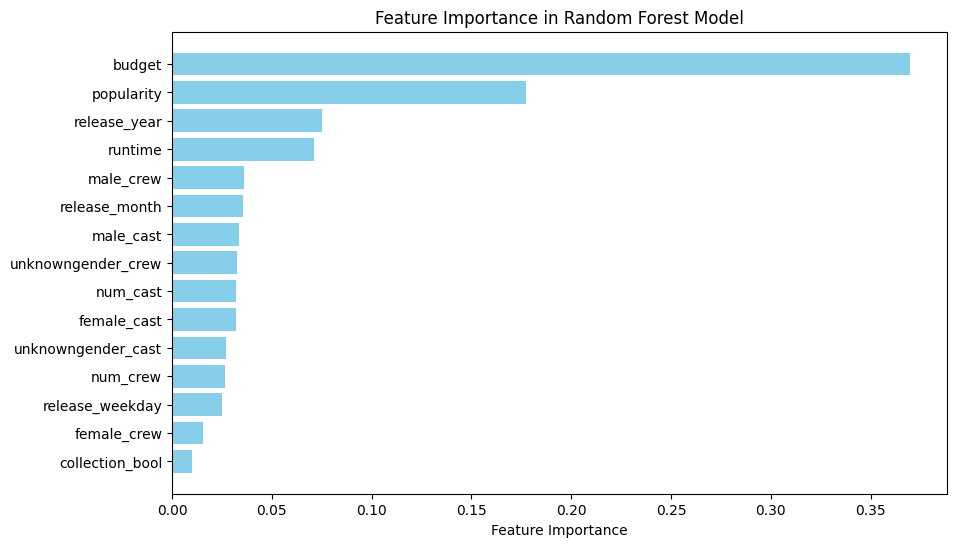

In [ ]:
# Extract feature importances
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort feature importances and their corresponding names
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest Model")
plt.show()

In [ ]:
# Initialize XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

# Fit the model on training data
xgb_model.fit(X_train, y_train)

# Step 6: Evaluate the model on training data
y_train_pred = xgb_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE with XGBoost: {train_rmse}")

# Step 7: Evaluate the model on testing data
y_test_pred = xgb_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Testing RMSE with XGBoost: {test_rmse}")

Training RMSE with XGBoost: 0.33575020851238463
Testing RMSE with XGBoost: 2.2673204084673917


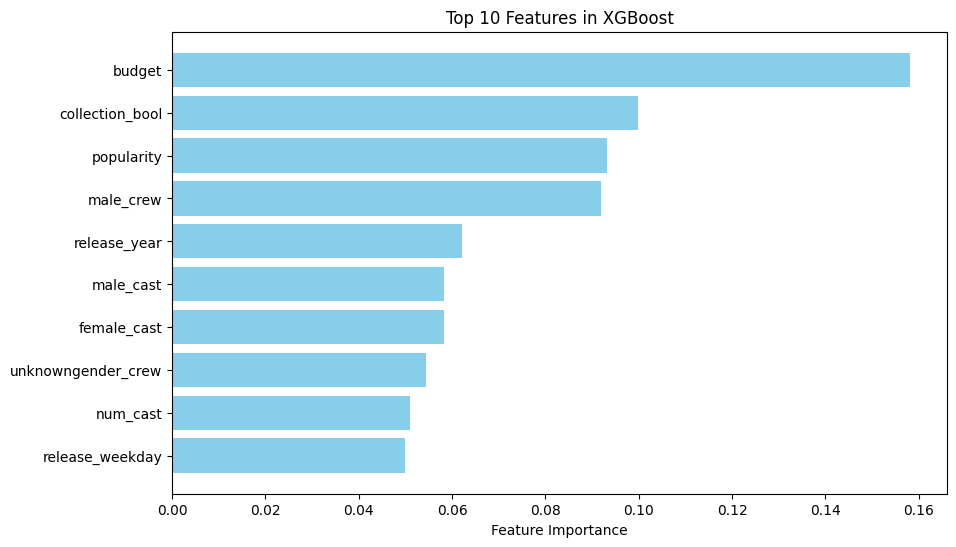

In [ ]:
# Extract feature importances
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot the custom feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[-10:], sorted_importances[-10:], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Features in XGBoost")
plt.show()